In [143]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from source.anomalyDetector import AnomalyDetector

## Autoencoder

#### Reading the data

In [203]:
ds_2025 = xr.open_dataset("files/2025_KVS_deployment_flagged.nc")
ds_2024 = xr.open_dataset("files/2024_KVS_deployment_flagged.nc")

In [204]:
ds_2025_1m_temp = ds_2025["temp_1m_calibrated"]
ds_2025_ir_temp = ds_2025["temp_snowsurface"]
ds_2025["temp_diff"] = ds_2025_1m_temp - ds_2025_ir_temp

ds_2024_1m_temp = ds_2024["temp_1m_calibrated"]
ds_2024_ir_temp = ds_2024["temp_snowsurface_calibrated"]
ds_2024["temp_diff"] = ds_2024_1m_temp - ds_2024_ir_temp

In [208]:
num_points = 0
for traj in range(ds_2025["trajectory"].size):
    if traj in [5,12,13]:
        continue
    temp = ds_2025.isel(trajectory=traj).time_temp.values
    temp = temp[~np.isnat(temp)]
    num_points = num_points + len(temp)
    print(traj,len(temp))

num_points

0 145
1 930
2 3090
3 173
4 1768
6 2858
7 3145
8 507
9 1933
10 35
11 35
14 1243
15 1688
16 1472
17 44
18 762
19 1006


20834

need to figure out what is wrong with bouy 5 and 12 but for now, bye bye

In [209]:
VERBOSE = True
variables = ["temp_1m_calibrated","temp_diff","temp_1m_quality_flag"]
num_vars = len(variables)
dataset = np.full((num_points,num_vars),np.nan)
row_start = 0
total = 0
for traj in range(ds_2025["trajectory"].size):
    if traj in [5,12,13]:
        continue
    
    print(f"Bouy nr. {traj}")
    ds_traj = ds_2025.isel(trajectory=traj)
    time_traj = ds_traj["time_temp"].values
    print(len(time_traj[~np.isnat(time_traj)]))
    col = 0
    for variable in variables:  
        #since all these arrays are indexed in the same order I should be able to go
        #variable by variable and add column by column, but maybe check this 
        
        data_var_val = ds_traj[variable].values
        data_var_val = data_var_val[~np.isnat(time_traj)]
      
        if col == 0: total = total + len(data_var_val)
        row_end = row_start + len(data_var_val)
        
        dataset[row_start:row_end,col] = data_var_val
        count = 0
        for val in data_var_val: 
            if np.isnan(val): print("FUUUUUUUUCKKKKK",count)
            count += 1

        if col == 0 and VERBOSE == True: 
            print(f"number of points: {len(data_var_val)}")
            print(f"row start:{row_start}, row_end:{row_end}")
        col += 1
    print("====================================================")

    row_start = row_end


print(np.shape(dataset))


Bouy nr. 0
145
number of points: 145
row start:0, row_end:145
Bouy nr. 1
930
number of points: 930
row start:145, row_end:1075
Bouy nr. 2
3090
number of points: 3090
row start:1075, row_end:4165
Bouy nr. 3
173
number of points: 173
row start:4165, row_end:4338
Bouy nr. 4
1768
number of points: 1768
row start:4338, row_end:6106
Bouy nr. 6
2858
number of points: 2858
row start:6106, row_end:8964
Bouy nr. 7
3145
number of points: 3145
row start:8964, row_end:12109
Bouy nr. 8
507
number of points: 507
row start:12109, row_end:12616
Bouy nr. 9
1933
number of points: 1933
row start:12616, row_end:14549
Bouy nr. 10
35
number of points: 35
row start:14549, row_end:14584
Bouy nr. 11
35
number of points: 35
row start:14584, row_end:14619
Bouy nr. 14
1243
number of points: 1243
row start:14619, row_end:15862
Bouy nr. 15
1688
number of points: 1688
row start:15862, row_end:17550
Bouy nr. 16
1472
number of points: 1472
row start:17550, row_end:19022
Bouy nr. 17
44
number of points: 44
row start:190

The data is now formatted as a matrix where the last column is the flags, the first is the 1m-temperature values, and the middle is the diff between 1m-temperature and surface temperature.

We then split the data into train and test.

In [211]:
labels = dataset[:,-1]
data = dataset[:,1:2]

In [212]:
idx_percent_20 = int(np.ceil(len(data)*0.2))
test_data = data[:idx_percent_20]
train_data = data[idx_percent_20:]


#### Scaling the data

Text(0.5, 1.0, 'Test data,\n 1m - surface 2025')

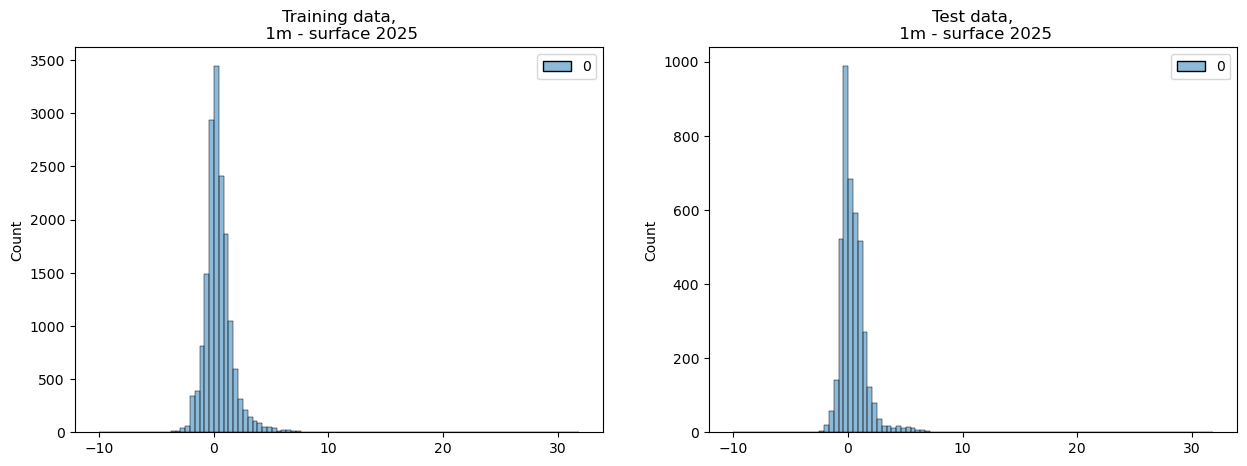

In [214]:
fig = plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(train_data, bins=100)

ax = plt.subplot(1,2,1)
sns.histplot(train_data,ax=ax,bins=bins)
ax.set_title("Training data,\n 1m - surface 2025")


ax1 = plt.subplot(1,2,2)
sns.histplot(test_data,ax=ax1,bins=bins)
ax1.set_title("Test data,\n 1m - surface 2025")

In [ ]:
autoencoder = AnomalyDetector()

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. 

reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)



